## Challenge: 3-bit greyscale steganography

In this challenge, the payload is an 8-bit greyscale image encoded in the least significant bits of the three colour channels. The fomula for the payload grey value is

$$ g = (r \bmod{2}) \times 2^2 + (g \bmod 2) \times 2^1 + (b \bmod 2) \times 2^0 $$

### Image prep

I got the payload image of a cat from https://www.monctonspca.ca/adopt-a-cat. I converted the colour image to 3-bit greyscale using ImageMagick:

```bash
convert cat.jpg -resize x330 -colorspace Gray -auto-level -depth 3 cat_sm.png
```

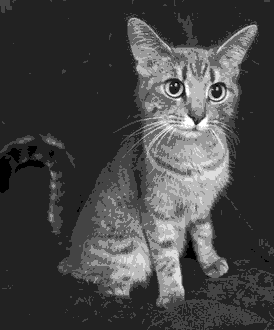

In [3]:
from PIL import Image
from IPython.display import display

payload = Image.open('cat_sm.png')
display(payload)

I decided to double the cat image, so that I could use more of the carrier.

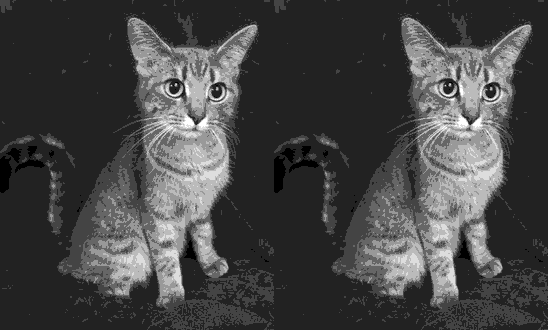

In [4]:
foo = Image.new('L', (payload.width * 2, payload.height))
foo.paste(payload)
foo.paste(payload, box=(payload.width, 0))
display(foo)
payload = foo

The carrier image is a picture of the Shediac lobster festival from http://www.tourismnewbrunswick.ca.

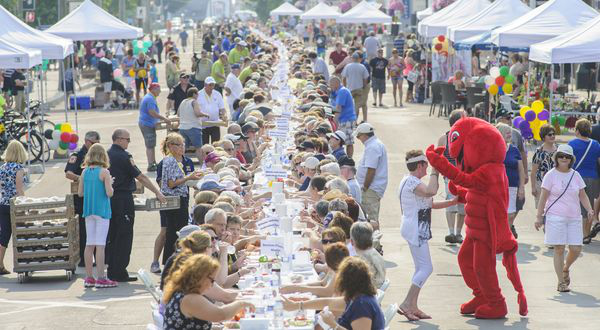

In [5]:
carrier = Image.open('LobsterFestival_039.jpg')
display(carrier)

### Encode the payload image in the least significant bits of the carrier

Each of the three colour channels will be used to express one bit: 0 if the colour value is even, and 1 if it's odd. This function is used to randomly nudge a given colour value up or down by 1 in order to produce the needed bit.

In [7]:
import random

def nudge(val, bit):
    '''change a single colour channel to produce the right bit'''
    
    if val % 2 != bit:
        # generate a list of possible adjustments:
        #  [-1, 1], unless current value is 0 or 255
        adj = []
        
        if val > 0:
            adj.append(-1)
        if val < 255:
            adj.append(1)
    
        # randomly choose one of the possible adjustments and apply it
        val = val + random.choice(adj)
        
    return val

Iterate over all pixels in the (doubled) payload, and nudge corresponding pixels of the carrier to produce the stego.

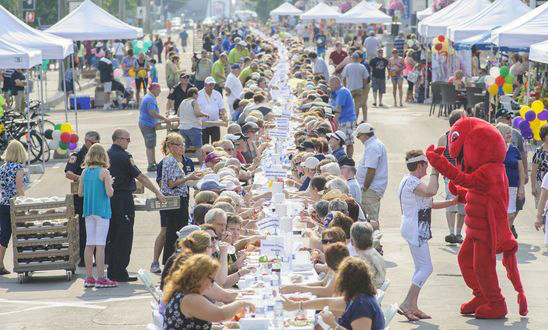

In [9]:
# Create a new image for the stego
stego = Image.new('RGB', payload.size)

for x in range(payload.width):
    for y in range(carrier.height):
        
        # get the grey value of the payload, scale down to range 0-7
        grey = payload.getpixel((x, y))
        grey = grey // 32
        
        # get the r, g, b channels of the carrier
        r, g, b = carrier.getpixel((x, y))
    
        # these are the bits we need
        bR = grey // 4
        bG = grey % 4 // 2
        bB = grey % 2
    
        # adjust the actual bits to match
        r = nudge(r, bR)
        g = nudge(g, bG)
        b = nudge(b, bB)

        # draw the pixel
        stego.putpixel((x, y), (r, g, b))

# show the result
display(stego)

### Decoding

Apply the formula given in the introduction to extract the payload image from the stego image.

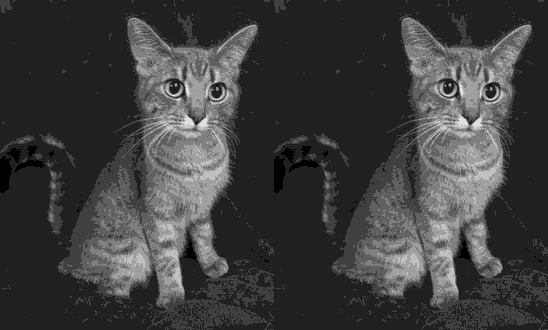

In [10]:
def unStego(img):
    res = Image.new('L', img.size)
    
    for x in range(img.width):
        for y in range(img.height):
            r, g, b = img.getpixel((x, y))
            
            grey = 32 * ((r % 2) * 4 + (g % 2) * 2 + (b % 2))
            
            res.putpixel((x, y), grey)
    
    return res

display(unStego(stego))

### Verify

Make sure the finished image works after save / reload

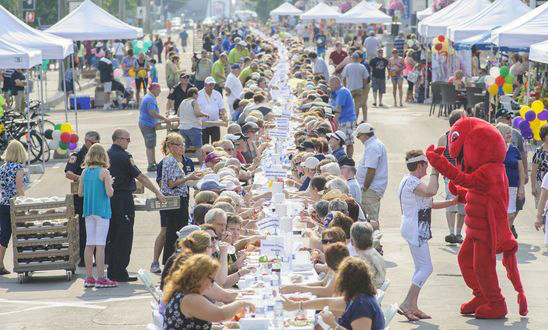

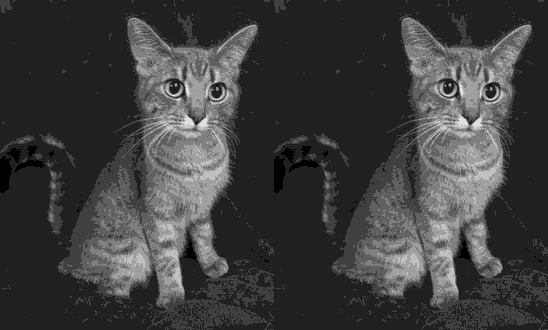

In [12]:
stego.save('stego_2.png')
foo = Image.open('stego_2.png')
display(foo)
display(unStego(foo))